In [4]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install opencv-python 
!pip install pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 7.0 MB/s eta 0:00:0000:0100:01


In [17]:
pip install jdc

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
import math
import jdc
from scipy.integrate import solve_ivp


from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

Пространство действий размерности 4:
1. Дать таблетку 1 вида
2. Дать таблетку 2 вида
3. Дать обе таблетки
4. Не давать таблетки

Пространство состояний размерности 7:  
$T \in (200, 800]$,  
$T_s \in (0, 500]$,   
$T_r \in (0, 500]$, (???)   
$V \in (0, 1000]$    
$V_s \in (0, 1000]$    
$V_r \in (0, 1000]$  
Область значений $\eta_1$ и $\eta_2$ состоит из 3500 значений для каждой функции, т.к. параметр $t$ может принимать не более 3500 значений _(посчитать для high и low значения)_   
$800 * 500^2 * 1000^3 * 4 * 3500^2 = 9,8*10^{23}$

За каждую следующую итерацию присваивается награда +1

Функция `reset` должна возвращать нас к следующему состоянию:  
$T(0) = 600  ед/мм^3$  
$T_s(0) = 0  ед/мм^3$  
$T_r(0) = 0  ед/мм^3$  
$V_s(0) = 10  ед/мм^3$  
$V_r(0) = 0  ед/мм^3$

Пусть состояние `done` наступает, если $T <= 200$ - проигрыш или $t = 3500$ - выигрыш

In [16]:
def eta1_func(t):
    return math.exp(- 0.5 * (t - 0))

def eta2_func(t):
    return max(math.exp(- 0.025 * (t - 0)), 0.15)

In [17]:
#constants
muT = 0.005
muTi = 0.25
kS = 0.0005
kr = 0.0005
kV = 0.0062
lambda1 = 0.025
lambda2 = 0.25
lambda3 = 0.8
Gs = 41.2
Gr = 41.2
V0 = 0.5
q = 1e-7
C = 47.0
C_i = 47.0
B = 2.0
Bs = 13.8
S1 = 4.0
S2 = 2.8
c1 = 0.5
c2 = 0.025
c3 = 0.15

In [51]:
def treatment_HIV(t, y, u1_a, u2_a):
    
    time = np.linspace(0, 3500)
    delta = time[1] - time[0]
    
    T, Ts, Tr, Vs, Vr, nu1, nu2 = y
    i = int(t // delta)

    V = Vs + Vr 
    u1 = u1_a[i]
    u2 = u2_a[i]
    S = S1 - S2 * V / (Bs + V)
    lam1 = lambda1 / (C + V)
    lam2 = lambda2 / (C_i + V)
    lam3 = lambda3 / (C_i + V)
    G = Gs * Vs / (B + V)
    if V < V0:
        Grv = 0
    else:
        Grv = Gs
   
    #система дифф уравнений описыващая динамику развития заболевания
    dTdt = S - muT * T + lam1 * T * V - (nu1 * kS * Vs + kr * Vr)*T
    dTsdt = nu1 * kS * Vs - muTi * Ts - lam2 * Ts * V
    dTrdt = kr * Vr * T - muTi * Tr - lam2 * Tr * V
    dVsdt = (1 - q) * lam3 * Ts * V - kV * T * Vs + nu2 * G
    dVrdt = lam3 * Tr * V + q * lam3 * Ts * V - kV * T * Vr + Grv * Vr / (B + V)
    dnu1dt = c1 * (1 -  nu1 - u1)
    dnu2dt = c2 * (1 - nu2 + u2 * (c3 - 1)) / (1 - c3)
    
    return np.array([dTdt, dTsdt, dTrdt, dVsdt, dVrdt, dnu1dt, dnu2dt])


In [52]:
class HIV(Env):
    def __init__(self):
        super(HIV, self).__init__()
        

        
        # Define a 3-D observation space: T, V
        self.observation_shape = (600, 1000) 
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
    
        
        # Define an action space ranging from 0 to 3
        self.action_space = spaces.Discrete(3,)
                        
        # Create a canvas to render the environment images upon 
        #self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Minimum parameters human can take 
        self.min_T = 200

        # Permissible area of parameters will be 
        


In [96]:
class Human(object):
    def __init__(self, name):
        self.init = np.array([600, 0, 0, 10, 0, 1, 1])
        self.name = name
        
        self.T_min = 200
        self.Ts_min = 0
        self.Tr_min = 0
        self.V_min = 0
        self.Vr_min = 0
        self.Vs_min = 0
        self.eta1_min = 9.65 * 10**(-761) # exp(-0.5 * (3500 - 0))
        self.eta2_min = 0.15 # max{exp(-0.025 * (3500 - 0)), 0.15}
        
        
        self.T_max = 800
        self.Ts_max = 500
        self.Tr_max = 500
        self.V_max = 1000
        self.Vr_max = 1000
        self.Vs_max = 1000
        self.eta1_max = 1
        self.eta2_max = 1
        
        self.values = np.zeros((10, 3500)) # t, T, Tr, Ts, Vr, Vs, eta1, eta2, u1, u2
        self.values[0] = np.array([i for i in range(3500)])
        
        self.values[1][0] = 600
        self.values[2][0] = 0
        self.values[3][0] = 0
        self.values[4][0] = 10
        self.values[5][0] = 0
        self.values[6][0] = 1
        self.values[7][0] = 1
        
    
    def set_position(self, t, T, Ts, Tr, Vs, Vr, eta1, eta2):
        self.values[1][t] = self.clamp(T, self.T_min, self.T_max)
        self.values[2][t] = self.clamp(Tr, self.Tr_min, self.Tr_max)
        self.values[3][t] = self.clamp(Ts, self.Ts_min, self.Ts_max)
        self.values[4][t] = self.clamp(Vs, self.Vs_min, self.Vs_max)
        self.values[5][t] = self.clamp(Vr, self.Vr_min, self.Vr_max)
        self.values[6][t] = self.clamp(eta1, self.eta1_min, self.eta1_max)
        self.values[7][t] = self.clamp(eta2, self.eta2_min, self.eta2_max)
    
    def get_position(self, t):
        position = [self.values[i][t] for i in range(1, 8)]
        return position
    
    def move(self, t, u1, u2):
        time = np.linspace(0, 3500)
        delta = time[1] - time[0]
        
        self.values[8][t], self.values[9][t] = u1, u2
        u1_array, u2_array = self.values[8], self.values[9]
        
        solution = solve_ivp(lambda t, y : treatment_HIV(t, y, u1_array, u2_array), (0, 3500), self.init, t_eval=time)
        
        for i in range(1, 8):
            self.values[i][t] = solution.y[i-1][t]


    def clamp(self, n, minn, maxn):
        return min(max(n, minn), maxn)
    
    def get_plot_cells(self, t):
        fig, ax = plt.subplots(figsize=(8, 6))
        fig.set_facecolor('white')

        plt.plot(self.values[0][:t], self.values[1][:t], '^-', label='T-cells')
        plt.plot(self.values[0][:t], self.values[4][:t], 'o-', label='sensitive virus $V_s$')
        plt.plot(self.values[0][:t], self.values[5][:t], '+-', label='resistant virus $V_r$')

        plt.ylabel('$T, V, units/cu. mm$')
        plt.xlabel('$Time, days$')
        plt.suptitle('HIV-infection dynamics')
        plt.legend()
        plt.ylim(0,700)
        plt.grid(True)


        plt.show()

In [77]:
%%add_to HIV

def reset(self):

    # Reset the reward
    self.ep_return  = 0

    
    # Intialise 
    self.human = Human("first")
    
    # Intialise the elements 
    self.elements = self.human

#     # Reset the Canvas 
#     self.canvas = np.ones(self.observation_shape) * 1

#     # Draw elements on the canvas
#     self.draw_elements_on_canvas()


    return self.human.get_position(0)

In [107]:
env = HIV()
obs = env.reset()
obs

[600.0, 0.0, 0.0, 10.0, 0.0, 1.0, 1.0]

In [103]:
%%add_to HIV

def render(self, t = 3500, mode = "human"):
    assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
    if mode == "human":
        return self.human.get_plot_cells(t)
    
    elif mode == "rgb_array":
        return self.human.values

# ГРАФИКИ

In [104]:
%%add_to HIV

def get_action_meanings(self):
    return {0: "Nothing", 1: "Get 1st pill", 2: "Get 2nd pill", 3: "Get both"}


In [105]:
%%add_to HIV

def step(self, action, t):
    # Flag that marks the termination of an episode
    done = False
    
    # Assert that it is a valid action 
    assert self.action_space.contains(action), "Invalid Action"
    
    # Reward for executing a step.
    reward = 1      

    # apply the action to the chopper
    if action == 0:
        self.human.move(t, 0, 0)
    elif action == 1:
        self.human.move(t, 1, 0)
    elif action == 2:
        self.human.move(t, 0, 1)
    elif action == 3:
        self.human.move(t, 1, 1)


    
    # Increment the episodic return
    self.ep_return += 1


    # If out of fuel, end the episode.
    if self.human.values[1][t] <= 200:
        done = True

    return [self.human.values[i][t] for i in range(1, 8)], reward, done, []

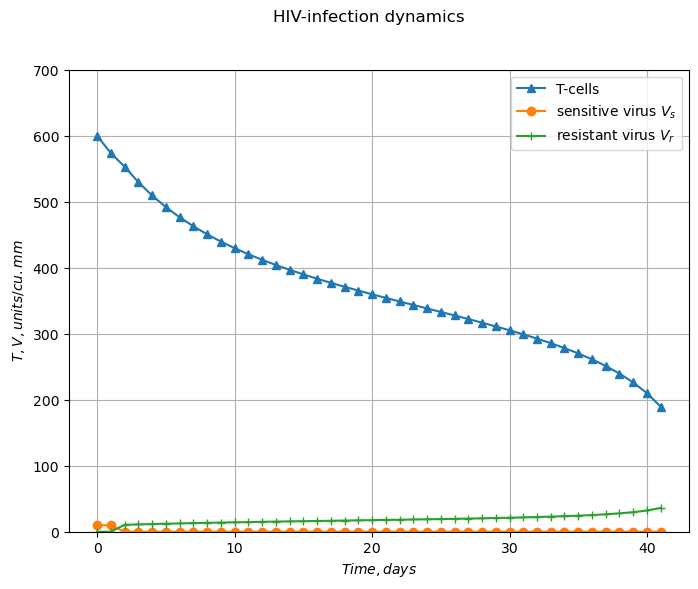

In [110]:
env.render(t=42, mode="human")

In [109]:
env = HIV()
obs = env.reset()
t = 0
reward_sum = 0

while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action, t)
    
    reward_sum += reward
    if reward_sum >= 3500:
        done = True
        
    print(obs, reward_sum, done, info)
    
    # Render the game
	#env.render()
    
    if done == True:
        break
        
    t += 1


[600.0, 0.0, 0.0, 10.0, 0.0, 1.0, 1.0] 1 False []
[573.5996854438343, 0.016357176174385934, 1.1259144300358864e-06, 9.577108611119046, 1.5356631529647425e-06, 1.0, 0.9986002570006426] 2 False []
[553.1738062458334, 1.6521728087284842e-09, 9.827194920406646, 1.041843718477781e-10, 10.519246084467978, 1.0, 0.2539239843137354] 3 False []
[529.6752219593579, 1.0430733149208696e-18, 9.860279331741381, 9.186082058422371e-19, 11.070244755318893, 1.0, 0.9084972551125724] 4 False []
[509.48060525805005, 1.5787328932821542e-27, 9.880827373849796, 2.4690557951767267e-25, 11.6344799087424, 1.0, 0.987363397667278] 5 False []
[491.93057755696896, 1.1997577848819441e-36, 9.901490206850541, 9.895823359412227e-38, 12.10334711381451, 1.0, 0.2526510901257004] 6 False []
[476.5287025980986, 5.182055099006206e-46, 9.912416659149747, 6.277086655073004e-46, 12.59863778098523, 0.9311481900129839, 0.9083257527295517] 7 False []
[462.8797030473118, 1.984905347233331e-55, 9.921220519750893, 2.1353014843989298e-5